In [1]:
import pandas as pd
from urllib.request import Request, urlopen
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
import re
import seaborn as sns
import gc
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tensorflow as tf
pd.set_option('display.max_rows', None)

In [ ]:
#from google.colab import drive 
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
df=pd.read_csv('../processed_data/vol_10mins_furtherpreprocess.csv').fillna(0)
df['tx_timestamp'] = pd.to_datetime(df['tx_timestamp'],unit='ns')
df = df.rename(columns = {"tx_timestamp":"timestamp","0":"volatility"})
display(df.head(3))
df.tail()

,timestamp,volatility
0,2020-05-26 21:00:00+00:00,0.0
1,2020-05-26 21:10:00+00:00,0.0
2,2020-05-26 21:20:00+00:00,0.0


,timestamp,volatility
127685,2022-10-30 13:50:00+00:00,0.007068
127686,2022-10-30 14:00:00+00:00,0.007478
127687,2022-10-30 14:10:00+00:00,0.006892
127688,2022-10-30 14:20:00+00:00,0.008923
127689,2022-10-30 14:30:00+00:00,0.006163


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127690 entries, 0 to 127689
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   timestamp   127690 non-null  datetime64[ns, UTC]
 1   volatility  127690 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 1.9 MB


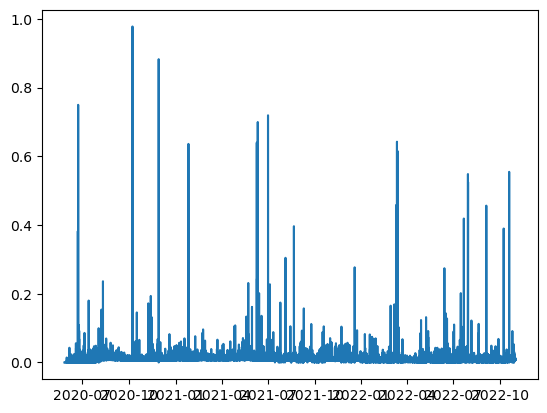

In [5]:
plt.plot(df['timestamp'],df['volatility'])

In [6]:
df.shape

(127690, 2)

In [17]:
train_start = '2020-05-26'
train_end = '2022-07-31'
dev_start = '2022-08-01'
dev_end = '2022-09-30'
test_start = '2022-10-01'
test_end = '2022-10-31'

In [18]:
train_dates = df[((df['timestamp'] >= train_start) & (df['timestamp'] <= train_end))]['volatility'].values.reshape((-1,1))
dev_dates = df[((df['timestamp'] >= dev_start) & (df['timestamp'] <= dev_end))]['volatility'].values.reshape((-1,1))
test_dates = df[((df['timestamp'] >= test_start) & (df['timestamp'] <= test_end))]['volatility'].values.reshape((-1,1))
train_dates.shape, dev_dates.shape, test_dates.shape

((114499, 1), (8641, 1), (4264, 1))

### Modelling

In [ ]:
#https://www.section.io/engineering-education/univariate-time-series-using-recurrent-neural-networks/
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#scaler.fit(train_dates)
#scaler.fit(dev_dates)
#scaler.fit(test_dates)

#scaled_train_dates = scaler.transform(train_dates)
#scaled_dev_dates = scaler.transform(dev_dates)
#scaled_test_dates = scaler.transform(test_dates)

In [ ]:
#scaled_test_dates[:10]

array([[0.01149256],
       [0.01141485],
       [0.01109328],
       [0.01150348],
       [0.01130069],
       [0.01180412],
       [0.01303157],
       [0.01088524],
       [0.0113229 ],
       [0.01136393]])

In [ ]:
#from keras.preprocessing.sequence import TimeseriesGenerator
#days_look_back = 2
#n_input = 24*6*days_look_back
#n_features = 1
#train_data_gen = TimeseriesGenerator(train_dates, train_dates,length=n_input, batch_size=1)
#dev_data_gen = TimeseriesGenerator(dev_dates, dev_dates,length=n_input, batch_size=1)

In [19]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = train_dates
# choose a number of time steps
days_look_back = 2
n_steps = 24*6*days_look_back
# split into samples
X, y = split_sequence(raw_seq, n_steps)

n_features = 1

In [20]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

#early_stopping = EarlyStopping(monitor = 'loss', patience=2, min_delta=1e-4)

model = Sequential()
model.add(LSTM(64,activation='relu',input_shape=(n_steps,n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss=tf.keras.losses.MeanAbsolutePercentageError())

num_epochs = 25

X = X.reshape((X.shape[0], X.shape[1], n_features))
history = model.fit(X, y, epochs=num_epochs)

Epoch 1/25
3570/3570 [==============================] - 1185s 332ms/step - loss: 15567.1465
Epoch 2/25
3570/3570 [==============================] - 1183s 332ms/step - loss: 14988.4912
Epoch 3/25
3570/3570 [==============================] - 1187s 332ms/step - loss: 14283.9092
Epoch 4/25
3570/3570 [==============================] - 1187s 333ms/step - loss: 13688.0000
Epoch 5/25
3570/3570 [==============================] - 1189s 333ms/step - loss: 15346.6416
Epoch 6/25
3570/3570 [==============================] - 1189s 333ms/step - loss: 13633.9980
Epoch 7/25
3570/3570 [==============================] - 1190s 333ms/step - loss: 13017.9268
Epoch 8/25
3570/3570 [==============================] - 1189s 333ms/step - loss: 14512.3721
Epoch 9/25
3570/3570 [==============================] - 1188s 333ms/step - loss: 15381.8779
Epoch 10/25
3570/3570 [==============================] - 1191s 334ms/step - loss: 14584.2764
Epoch 11/25
3570/3570 [==============================] - 1191s 334ms/step - los

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [22]:
model_save_name = 'lstm64_dense_ep25_baseline_mape'
model.save('model_{}.h5'.format(model_save_name))

In [ ]:
#import tensorflow as tf
#from tensorflow import keras
#new_model = tf.keras.models.load_model('/content/gdrive/My Drive/cs230models/model_{}.h5'.format(model_save_name))

# Check its architecture
#new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#model.evaluate_generator(dev_data_gen)
#trainPredict = model.predict_generator(train_data_gen)
#devPredict = model.predict_generator(dev_data_gen)

In [23]:
X_dev, y_dev = split_sequence(dev_dates, n_steps)
X_dev = X_dev.reshape((X_dev.shape[0], n_steps, n_features))
y_dev_pred = model.predict(X_dev)
y_train_pred = model.predict(X.reshape((X.shape[0], n_steps, n_features)))
print(y_dev_pred.shape, y_train_pred.shape)
from sklearn.metrics import mean_absolute_percentage_error
print(mean_absolute_percentage_error(y_dev_pred, dev_dates[24*6*days_look_back:]))
print(mean_absolute_percentage_error(y_train_pred, train_dates[24*6*days_look_back:]))

(8353, 1) (114211, 1)
36.764655342213
43.58805823438085


In [25]:
##train stacked LSTM overnight

In [26]:
# define input sequence
raw_seq = train_dates
# choose a number of time steps
days_look_back = 7
n_steps = 24*6*days_look_back
# split into samples
X, y = split_sequence(raw_seq, n_steps)

n_features = 1

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

#early_stopping = EarlyStopping(monitor = 'loss', patience=2, min_delta=1e-4)

model1 = Sequential()
model1.add(LSTM(64,activation='relu',return_sequences=True, input_shape=(n_steps,n_features)))
model1.add(LSTM(32, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.compile(optimizer='adam', loss=tf.keras.losses.MeanAbsolutePercentageError())

num_epochs = 25

X = X.reshape((X.shape[0], X.shape[1], n_features))
history = model1.fit(X, y, epochs=num_epochs)

Epoch 1/25
3547/3547 [==============================] - 8857s 2s/step - loss: 14826.4521
Epoch 2/25
3547/3547 [==============================] - 8849s 2s/step - loss: 13591.6650
Epoch 3/25
3547/3547 [==============================] - 8861s 2s/step - loss: 12614.7012
Epoch 4/25
3547/3547 [==============================] - 8862s 2s/step - loss: 14298.3945
Epoch 5/25
3547/3547 [==============================] - 8862s 2s/step - loss: 12116.7949
Epoch 6/25
3547/3547 [==============================] - 8890s 3s/step - loss: 12877.0283
Epoch 7/25
3547/3547 [==============================] - 8877s 3s/step - loss: 13842.5488
Epoch 8/25
3547/3547 [==============================] - 8879s 3s/step - loss: 13127.1533
Epoch 9/25
1464/3547 [===========>..................] - ETA: 1:26:51 - loss: 11806.8799

In [ ]:
model1.summary()

In [ ]:
model_save_name = 'lstm6432_dense_ep25_back7_mape'
model1.save('model_{}.h5'.format(model_save_name))

In [ ]:
X_dev, y_dev = split_sequence(dev_dates, n_steps)
X_dev = X_dev.reshape((X_dev.shape[0], n_steps, n_features))
y_dev_pred = model1.predict(X_dev)
y_train_pred = model1.predict(X.reshape((X.shape[0], n_steps, n_features)))
print(y_dev_pred.shape, y_train_pred.shape)
from sklearn.metrics import mean_absolute_percentage_error
print(mean_absolute_percentage_error(y_dev_pred, dev_dates[24*6*days_look_back:]))
print(mean_absolute_percentage_error(y_train_pred, train_dates[24*6*days_look_back:]))